**Cell 1 – Import & tiện ích hiển thị**

In [23]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

%matplotlib inline

print("OpenCV version:", cv2.__version__)

def plot_images(*imgs, titles=None, figsize=(15,5), hide_ticks=True):
    """
    Hiển thị 1 hoặc nhiều ảnh (BGR/RGB).
    """
    n = len(imgs)
    cols = min(n, 3)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=figsize)
    for i, img in enumerate(imgs, 1):
        plt.subplot(rows, cols, i)
        if img is None:
            continue
        if img.ndim == 3:
            img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_show = img
        plt.imshow(img_show, cmap='gray' if img.ndim == 2 else None)
        if titles and i-1 < len(titles):
            plt.title(titles[i-1])
        if hide_ticks:
            plt.axis('off')
    plt.tight_layout()
    plt.show()


OpenCV version: 4.12.0


**Cell 2 – Hàm SIFT: detector + matching**

In [7]:
def create_sift_detector():
    """
    Tạo SIFT detector + norm type cho BFMatcher.
    """
    sift = cv2.SIFT_create()
    norm_type = cv2.NORM_L2
    return sift, norm_type

def match_sift_keypoints(des1, des2, norm_type, ratio_thresh=0.75):
    """
    Matching đặc trưng SIFT bằng BFMatcher + KNN + ratio test (Lowe).
    """
    bf = cv2.BFMatcher(norm_type, crossCheck=False)
    raw_matches = bf.knnMatch(des1, des2, k=2)
    good = [m for m, n in raw_matches if m.distance < ratio_thresh * n.distance]
    return good


**Cell 3 – Hàm ghép panorama bằng SIFT (bản cải tiến, đã fix lỗi)**

In [8]:
def stitch_two_images_sift(img_left, img_right,
                           ratio_thresh=0.75,
                           min_matches=10,
                           debug=False,
                           num_matches_to_draw=50):
    """
    Ghép img_right vào bên phải img_left bằng SIFT.
    Trả về: panorama_bgr, good_matches, kp1, kp2
    """

    # 0. Tạo SIFT detector
    sift, norm_type = create_sift_detector()

    # 1. Chuyển sang xám
    gray1 = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    # 2. Tìm keypoints + descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    print(f"[SIFT] keypoints ảnh trái: {len(kp1)}, ảnh phải: {len(kp2)}")

    # 3. Matching SIFT
    good_matches = match_sift_keypoints(des1, des2, norm_type, ratio_thresh)
    print(f"[SIFT] Số match tốt: {len(good_matches)}")

    if len(good_matches) < min_matches:
        raise ValueError(f"Quá ít match tốt (={len(good_matches)}), "
                         "hãy chụp ảnh overlap nhiều hơn hoặc chỉnh ratio_thresh.")

    # 4. Lấy toạ độ điểm tương ứng
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # 5. Tính homography (RANSAC)
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 4.0)
    if H is None:
        raise ValueError("Không tìm được homography phù hợp!")

    # 6. Warp ảnh phải
    h1, w1 = img_left.shape[:2]
    h2, w2 = img_right.shape[:2]

    pano_w = w1 + w2
    pano_h = max(h1, h2)

    warped_right = cv2.warpPerspective(img_right, H, (pano_w, pano_h))

    # 7. Canvas cho left & right (cùng kích thước)
    canvas_left  = np.zeros_like(warped_right)
    canvas_right = warped_right.copy()

    canvas_left[0:h1, 0:w1] = img_left

    # 8. Mask cho blending
    mask_left  = (canvas_left.sum(axis=2)  > 0)
    mask_right = (canvas_right.sum(axis=2) > 0)

    panorama = np.zeros_like(warped_right)

    only_l  = mask_left & ~mask_right
    only_r  = ~mask_left & mask_right
    overlap = mask_left & mask_right

    # vùng chỉ có ảnh trái
    panorama[only_l] = canvas_left[only_l]
    # vùng chỉ có ảnh phải
    panorama[only_r] = canvas_right[only_r]

    # vùng chồng lắp: trung bình 2 ảnh
    if np.any(overlap):
        left_overlap  = canvas_left[overlap].astype(np.float32)
        right_overlap = canvas_right[overlap].astype(np.float32)
        blended = 0.5 * left_overlap + 0.5 * right_overlap
        panorama[overlap] = blended.astype(np.uint8)

    # 9. Cắt phần đen dư bên phải
    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_pan, 1, 255, cv2.THRESH_BINARY)
    cols = np.where(np.max(thresh, axis=0) > 0)[0]
    if len(cols) > 0:
        max_col = cols[-1]
        panorama = panorama[:, :max_col+1]

       # 10. (tuỳ chọn) Vẽ match SIFT
       # 10. (tuỳ chọn) Vẽ match SIFT
    if debug and num_matches_to_draw > 0:
        max_draw = min(num_matches_to_draw, len(good_matches))
        matches_to_draw = good_matches[:max_draw]
        match_img = cv2.drawMatches(
            img_left, kp1, img_right, kp2,
            matches_to_draw, None,
            matchColor=(0,0,255),
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plot_images(match_img, titles=[f"SIFT - {max_draw} match tốt"])

    return panorama, good_matches, kp1, kp2


**Cell 4 – Đọc ảnh src_left_2_2 & src_right_2**

Kích thước ảnh trái: (512, 384, 3)
Kích thước ảnh phải: (512, 384, 3)


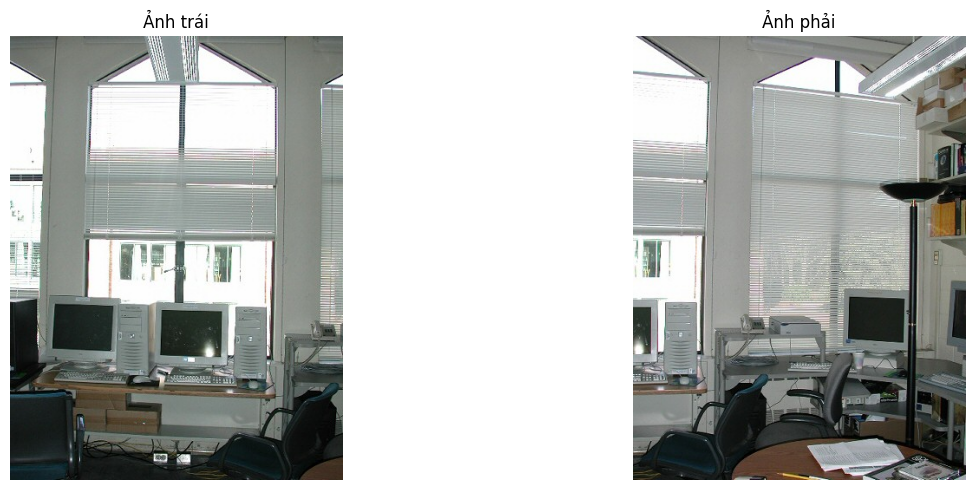

In [27]:
base_dir = r"C:\Users\Public\panorama_sift"

left_name  = "src_left_2.jpg"
right_name = "src_right_2.jpg"

path_left  = os.path.join(base_dir, left_name)
path_right = os.path.join(base_dir, right_name)

img_left  = cv2.imread(path_left)
img_right = cv2.imread(path_right)

if img_left is None:
    raise FileNotFoundError(f"Không đọc được ảnh trái: {path_left}")
if img_right is None:
    raise FileNotFoundError(f"Không đọc được ảnh phải: {path_right}")

print("Kích thước ảnh trái:", img_left.shape)
print("Kích thước ảnh phải:", img_right.shape)

plot_images(img_left, img_right, titles=["Ảnh trái", "Ảnh phải"])


**Cell 5 – Ghép panorama bằng SIFT + lưu kết quả**

[SIFT] keypoints ảnh trái: 585, ảnh phải: 601
[SIFT] Số match tốt: 96


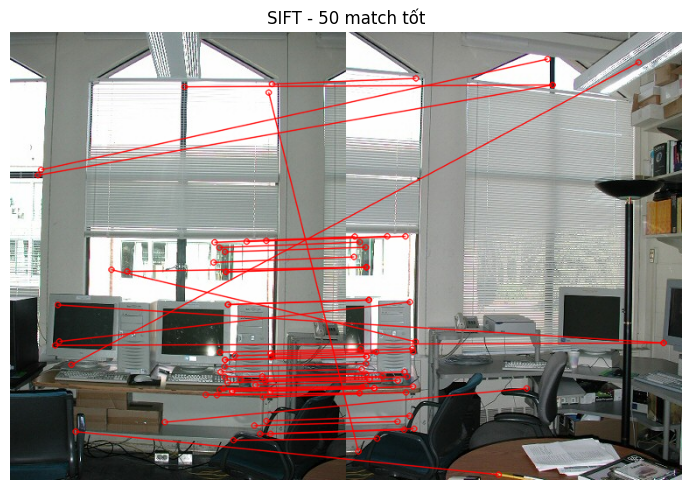

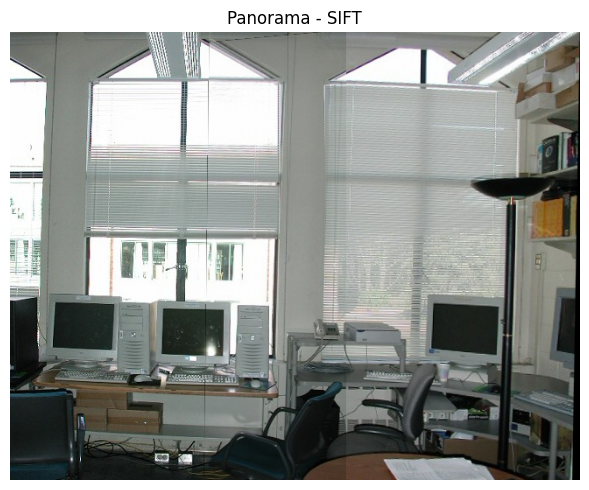

Đã lưu ảnh panorama (SIFT) tại: C:\Users\Public\panorama_sift\panorama_sift_result_grail.jpg


In [17]:
panorama_bgr, good_matches_sift, kp1_sift, kp2_sift = stitch_two_images_sift(
    img_left, img_right,
    ratio_thresh=0.75,
    min_matches=15,
    debug=True,
    num_matches_to_draw=50   # <- muốn bao nhiêu thì chỉnh ở đây
)

plot_images(panorama_bgr, titles=["Panorama - SIFT"])

out_path_sift = os.path.join(base_dir, "panorama_sift_result_grail.jpg")
cv2.imwrite(out_path_sift, panorama_bgr)
print("Đã lưu ảnh panorama (SIFT) tại:", out_path_sift)


**Cell 6 – Hàm ORB (detector + match + stitch riêng)**

In [11]:
def create_orb_detector():
    """
    Tạo ORB detector + norm type cho BFMatcher.
    """
    orb = cv2.ORB_create()
    norm_type = cv2.NORM_HAMMING
    return orb, norm_type

def match_orb_keypoints(des1, des2, norm_type):
    """
    Matching ORB dùng BFMatcher với crossCheck (giống nhiều ví dụ GitHub).
    """
    bf = cv2.BFMatcher(norm_type, crossCheck=True)
    raw_matches = bf.match(des1, des2)
    good = sorted(raw_matches, key=lambda x: x.distance)
    return good

def stitch_two_images_orb(img_left, img_right,
                          min_matches=10,
                          max_draw_matches=50,
                          debug=False):
    """
    Ghép img_right vào bên phải img_left dùng ORB.
    Trả về: panorama_bgr, good_matches, kp1, kp2
    """
    orb, norm_type = create_orb_detector()

    gray1 = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    print(f"[ORB] keypoints ảnh trái: {len(kp1)}, ảnh phải: {len(kp2)}")

    good_matches = match_orb_keypoints(des1, des2, norm_type)
    print(f"[ORB] Tổng match (đã sort theo distance): {len(good_matches)}")

    # dùng một số match tốt nhất
    good_subset = good_matches[:max(4*min_matches, min(len(good_matches), 200))]
    print(f"[ORB] Sử dụng {len(good_subset)} match để ước lượng homography")

    if len(good_subset) < min_matches:
        raise ValueError(f"[ORB] Quá ít match tốt (={len(good_subset)})")

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_subset]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_subset]).reshape(-1,1,2)

    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 4.0)
    if H is None:
        raise ValueError("[ORB] Không tìm được homography phù hợp!")

    h1, w1 = img_left.shape[:2]
    h2, w2 = img_right.shape[:2]

    pano_w = w1 + w2
    pano_h = max(h1, h2)

    warped_right = cv2.warpPerspective(img_right, H, (pano_w, pano_h))

    # dùng lại cách blending giống SIFT để tiện so sánh
    canvas_left  = np.zeros_like(warped_right)
    canvas_right = warped_right.copy()

    canvas_left[0:h1, 0:w1] = img_left

    mask_left  = (canvas_left.sum(axis=2)  > 0)
    mask_right = (canvas_right.sum(axis=2) > 0)

    panorama = np.zeros_like(warped_right)

    only_l  = mask_left & ~mask_right
    only_r  = ~mask_left & mask_right
    overlap = mask_left & mask_right

    panorama[only_l] = canvas_left[only_l]
    panorama[only_r] = canvas_right[only_r]

    if np.any(overlap):
        left_overlap  = canvas_left[overlap].astype(np.float32)
        right_overlap = canvas_right[overlap].astype(np.float32)
        blended = 0.5 * left_overlap + 0.5 * right_overlap
        panorama[overlap] = blended.astype(np.uint8)

    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_pan, 1, 255, cv2.THRESH_BINARY)
    cols = np.where(np.max(thresh, axis=0) > 0)[0]
    if len(cols) > 0:
        max_col = cols[-1]
        panorama = panorama[:, :max_col+1]

    if debug:
        max_draw = min(max_draw_matches, len(good_subset))
        matches_to_draw = good_subset[:max_draw]
        match_img = cv2.drawMatches(
            img_left, kp1, img_right, kp2,
            matches_to_draw, None,
            matchColor=(0,255,0),
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plot_images(match_img, titles=[f"ORB - {max_draw} match tốt"])

    return panorama, good_subset, kp1, kp2


**Cell 7 – So sánh nhanh SIFT vs ORB (mở rộng)**

Ghép panorama bằng SIFT...
[SIFT] keypoints ảnh trái: 585, ảnh phải: 601
[SIFT] Số match tốt: 96
Ghép panorama bằng ORB...
[ORB] keypoints ảnh trái: 500, ảnh phải: 499
[ORB] Tổng match (đã sort theo distance): 142
[ORB] Sử dụng 142 match để ước lượng homography
SIFT: kp trái/phải = 585/601, matches = 96, time = 0.151s
ORB : kp trái/phải = 500/499, matches = 142, time = 0.417s


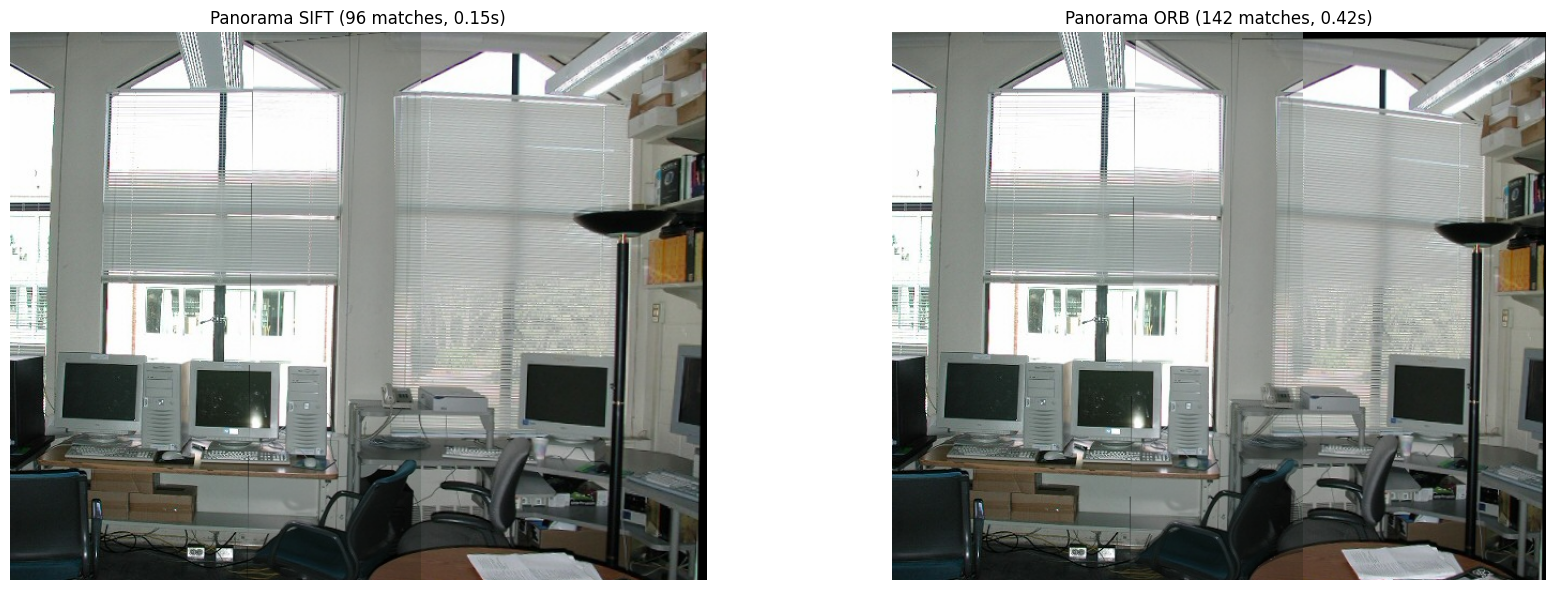

In [12]:
import time

# SIFT
print("="*60)
print("Ghép panorama bằng SIFT...")
t0 = time.time()
pano_sift, gm_sift, kp1_sift, kp2_sift = stitch_two_images_sift(
    img_left, img_right,
    ratio_thresh=0.75,
    min_matches=15,
    debug=False
)
t1 = time.time()

# ORB
print("="*60)
print("Ghép panorama bằng ORB...")
t2 = time.time()
pano_orb, gm_orb, kp1_orb, kp2_orb = stitch_two_images_orb(
    img_left, img_right,
    min_matches=15,
    max_draw_matches=80,
    debug=False
)
t3 = time.time()

print("="*60)
print(f"SIFT: kp trái/phải = {len(kp1_sift)}/{len(kp2_sift)}, "
      f"matches = {len(gm_sift)}, time = {t1 - t0:.3f}s")
print(f"ORB : kp trái/phải = {len(kp1_orb)}/{len(kp2_orb)}, "
      f"matches = {len(gm_orb)}, time = {t3 - t2:.3f}s")

plot_images(
    pano_sift, pano_orb,
    titles=[
        f"Panorama SIFT ({len(gm_sift)} matches, {t1 - t0:.2f}s)",
        f"Panorama ORB ({len(gm_orb)} matches, {t3 - t2:.2f}s)"
    ],
    figsize=(18,6)
)
